# 🚢 Titanic Survival Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin

train_df = pd.read_csv('dataset/train.csv')

test_df = pd.read_csv('dataset/test.csv')

In [3]:
#test_df.head()
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 🔍 Exploratory Data Analysis (EDA)

In [5]:
train_df.info()
print("\n\n---------------------------------\n\n")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId 

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


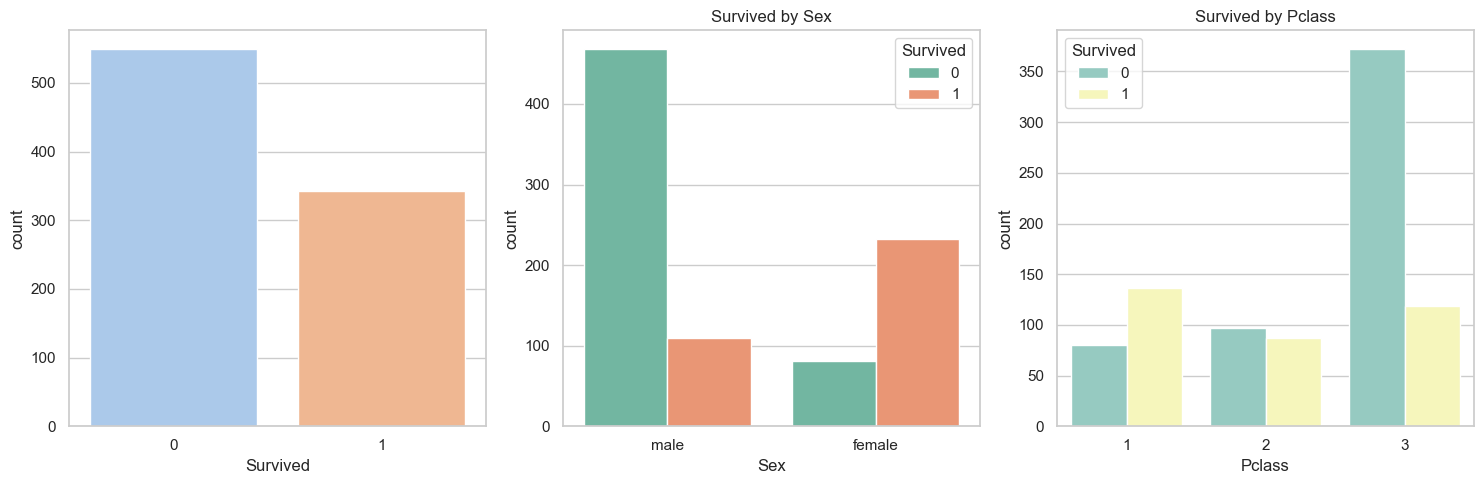

In [7]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Survived
sns.countplot(x="Survived", hue="Survived", data=train_df, ax=axes[0], palette="pastel", legend=False)

# Survived by Sex
sns.countplot(x='Sex', hue='Survived', data=train_df, ax=axes[1], palette="Set2")
axes[1].set_title('Survived by Sex')

# Survived by Pclass
sns.countplot(x='Pclass', hue='Survived', data=train_df, ax=axes[2], palette="Set3")
axes[2].set_title('Survived by Pclass')

plt.tight_layout()
plt.show()

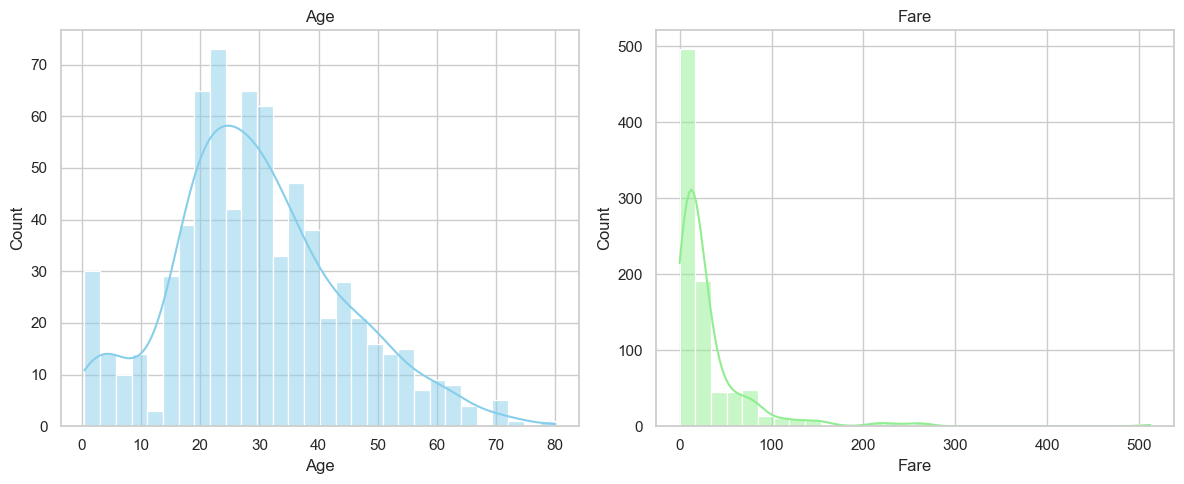

In [8]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Age
sns.histplot(train_df['Age'].dropna(), kde=True, bins=30, ax=axes[0], color="skyblue")
axes[0].set_title("Age")

# Fare
sns.histplot(train_df['Fare'].dropna(), kde=True, bins=30, ax=axes[1], color="lightgreen")
axes[1].set_title("Fare")

plt.tight_layout()
plt.show()


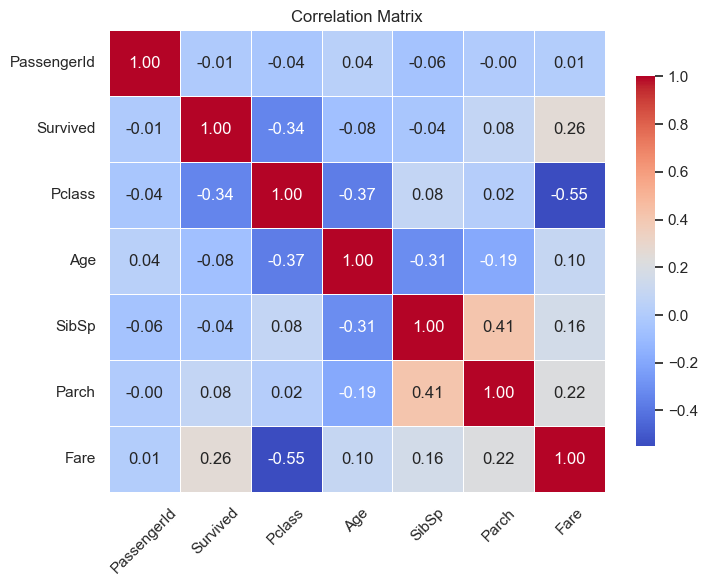

In [9]:
plt.figure(figsize=(8, 6))
corr_matrix = train_df.corr(numeric_only=True)

sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f", 
            linewidths=0.5, 
            cbar_kws={'shrink': 0.8})  

plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


# 🛠 Feature Engineering

- Extract Title from passenger names
- Create Family Size feature
- Fill missing values
- Drop irrelevant columns

In [10]:
class TitleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column="Name"):
        self.column = column
        self.rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 
                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        def extract_title(name):
            if pd.isnull(name):
                return "Unknown"
            title = name.split(",")[1].split(".")[0].strip()
            if title in self.rare_titles:
                return "Rare"
            return title
        X_transformed["Title"] = X_transformed[self.column].apply(extract_title)
        return X_transformed[["Title"]]
    
class FamilySizeWithAlone(BaseEstimator, TransformerMixin):
    
    def __init__(self, sibsp_col="SibSp", parch_col="Parch"):
        self.sibsp_col = sibsp_col
        self.parch_col = parch_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed["FamilySize"] = X_transformed[self.sibsp_col] + X_transformed[self.parch_col] + 1
        X_transformed["IsAlone"] = (X_transformed["FamilySize"] == 1).astype(int)
        return X_transformed[["FamilySize", "IsAlone"]]

In [11]:
# Create a preprocessing pipeline

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

title_pipeline = Pipeline(steps=[
    ("extract", TitleExtractor(column="Name")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

family_pipeline = Pipeline(steps=[
    ("extract", FamilySizeWithAlone(sibsp_col="SibSp", parch_col="Parch")),
    ("scaler", StandardScaler())
])

In [ ]:
# Combine transformers using ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, make_column_selector(dtype_include=["int64", "float64"])),
    ("cat", categorical_pipeline, make_column_selector(dtype_include=["object", "category"])),
    ("title", title_pipeline, ["Name"]),
    ("family", family_pipeline, ["SibSp", "Parch"])
])

In [36]:
passenger_ids = test_df["PassengerId"]
X_train = train_df.drop(columns=["Survived"])
y_train = train_df['Survived']
X_test = test_df

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5124 stored elements and shape (418, 1741)>
  Coords	Values
  (0, 0)	1.7339958399701274
  (0, 1)	0.8273772438659699
  (0, 2)	0.3948865804412651
  (0, 3)	-0.47454519624983954
  (0, 4)	-0.4736736092984604
  (0, 5)	-0.49078316061772326
  (0, 439)	1.0
  (0, 898)	1.0
  (0, 1627)	1.0
  (0, 1728)	1.0
  (0, 1734)	1.0
  (0, 1739)	-0.5609748304808925
  (0, 1740)	0.8119223343984152
  (1, 0)	1.7378837230193878
  (1, 1)	0.8273772438659699
  (1, 2)	1.3555096219574048
  (1, 3)	0.4327933656785018
  (1, 4)	-0.4736736092984604
  (1, 5)	-0.5074788432328381
  (1, 897)	1.0
  (1, 1627)	1.0
  (1, 1729)	1.0
  (1, 1735)	1.0
  (1, 1739)	0.059159876663617626
  (1, 1740)	-1.2316448970959013
  :	:
  (416, 0)	3.3513551884624437
  (416, 1)	0.8273772438659699
  (416, 2)	-0.10463740114712752
  (416, 3)	-0.47454519624983954
  (416, 4)	-0.4736736092984604
  (416, 5)	-0.4863374216869257
  (416, 898)	1.0
  (416, 1627)	1.0
  (416, 1729)	1.0
  (416, 1734)	1.0
  (

In [19]:
# Get column names after one-hot encoding

ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

In [20]:
# Convert back to DataFrame for easier inspection (optional, you can go directly to the model)
combined_processed_df = pd.DataFrame(combined_processed, columns=all_feature_names)

print("\nData after preprocessing (first 5 rows):")
print(combined_processed_df.head())


Data after preprocessing (first 5 rows):
        Age      Fare     SibSp  Parch  Pclass_1  Pclass_2  Pclass_3  \
0 -0.581628 -0.503291  0.481288 -0.445       0.0       0.0       1.0   
1  0.658652  0.734744  0.481288 -0.445       1.0       0.0       0.0   
2 -0.271558 -0.490240 -0.479087 -0.445       0.0       0.0       1.0   
3  0.426099  0.383183  0.481288 -0.445       1.0       0.0       0.0   
4  0.426099 -0.487824 -0.479087 -0.445       0.0       0.0       1.0   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         0.0       1.0         0.0         0.0         1.0  
1         1.0       0.0         1.0         0.0         0.0  
2         1.0       0.0         0.0         0.0         1.0  
3         1.0       0.0         0.0         0.0         1.0  
4         0.0       1.0         0.0         0.0         1.0  


In [21]:
# Split back the training and testing data
X_train_processed = combined_processed_df.iloc[:len(train_df)]
X_test_processed = combined_processed_df.iloc[len(train_df):]
y_train = train_labels

In [22]:
# Define the models to be tested
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

In [ ]:
# Train and evaluate each model using Cross-Validation

results = {}

for name, model in models.items():
    print(f"\nTraining and evaluating {name}...")

    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='accuracy')
    model.fit(X_train_processed, y_train)
    y_pred_train = model.predict(X_train_processed)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    results[name] = {
        'CV Mean Accuracy': cv_scores.mean(),
        'CV Std Dev': cv_scores.std(),
        'Train Accuracy': train_accuracy,
        'Model': model
    }
    print(f"CV Mean Accuracy: {results[name]['CV Mean Accuracy']:.4f}")
    print(f"Train Accuracy: {results[name]['Train Accuracy']:.4f}")


Training and evaluating Logistic Regression...
  CV Mean Accuracy: 0.7924
  Train Accuracy: 0.8058

Training and evaluating Decision Tree...
  CV Mean Accuracy: 0.7834
  Train Accuracy: 0.9798

Training and evaluating Random Forest...
  CV Mean Accuracy: 0.8103
  Train Accuracy: 0.9798

Training and evaluating Gradient Boosting...
  CV Mean Accuracy: 0.8238
  Train Accuracy: 0.9035

Training and evaluating Support Vector Machine...
  CV Mean Accuracy: 0.8272
  Train Accuracy: 0.8384


In [24]:
best_model_name = sorted(results.items(), key=lambda item: item[1]['CV Mean Accuracy'], reverse=True)[0][0]
print(f"Best model: {best_model_name}")
model_to_tune = models[best_model_name]

Best model: Support Vector Machine


In [25]:
# Define parameter grid for GridSearchCV
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1.0, 10.0]
    }
elif best_model_name == 'Support Vector Machine':
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['rbf', 'linear']
    }
else:  # Decision Tree
    param_grid = {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10]
    }

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(model_to_tune, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_processed, y_train)

print(f"\nBest parameters for {best_model_name}: {grid_search.best_params_}")
print(f"Best cross-validation accuracy for {best_model_name}: {grid_search.best_score_:.4f}")

# Get the final tuned model
final_model = grid_search.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters for Support Vector Machine: {'C': 1.0, 'kernel': 'rbf'}
Best cross-validation accuracy for Support Vector Machine: 0.8272


In [26]:
y_test_pred = final_model.predict(X_test_processed)

submission_df = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': y_test_pred
})
submission_df['Survived'] = submission_df['Survived'].astype(int)

output_folder = 'output'
submission_file_path = f'{output_folder}/submission_titanic.csv'

# Create folder if it doesn't exist
import os
os.makedirs(output_folder, exist_ok=True)

# Save CSV file to the folder
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file successfully created: {submission_file_path}")
print(submission_df.head())


Submission file successfully created: output/submission_titanic.csv
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
